In [253]:
import copy
from glob import glob
from io import open
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os, random
from PIL import Image
import requests
import shutil
import time

import torch
from torch.autograd import Variable
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

plt.ion()   # interactive mode

%matplotlib inline

In [233]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(1.0, 1.1), shear=5, resample=False, fillcolor=0),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.5),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),    
}

data_dir = 'dogImages'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
n_classes = len(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [175]:
image_datasets['val'].classes

['001.Affenpinscher',
 '002.Afghan_hound',
 '003.Airedale_terrier',
 '004.Akita',
 '005.Alaskan_malamute',
 '006.American_eskimo_dog',
 '007.American_foxhound',
 '008.American_staffordshire_terrier',
 '009.American_water_spaniel',
 '010.Anatolian_shepherd_dog',
 '011.Australian_cattle_dog',
 '012.Australian_shepherd',
 '013.Australian_terrier',
 '014.Basenji',
 '015.Basset_hound',
 '016.Beagle',
 '017.Bearded_collie',
 '018.Beauceron',
 '019.Bedlington_terrier',
 '020.Belgian_malinois',
 '021.Belgian_sheepdog',
 '022.Belgian_tervuren',
 '023.Bernese_mountain_dog',
 '024.Bichon_frise',
 '025.Black_and_tan_coonhound',
 '026.Black_russian_terrier',
 '027.Bloodhound',
 '028.Bluetick_coonhound',
 '029.Border_collie',
 '030.Border_terrier',
 '031.Borzoi',
 '032.Boston_terrier',
 '033.Bouvier_des_flandres',
 '034.Boxer',
 '035.Boykin_spaniel',
 '036.Briard',
 '037.Brittany',
 '038.Brussels_griffon',
 '039.Bull_terrier',
 '040.Bulldog',
 '041.Bullmastiff',
 '042.Cairn_terrier',
 '043.Canaan_do

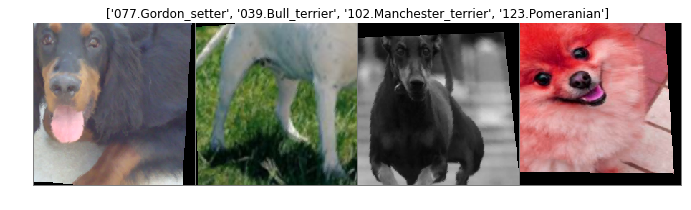

In [54]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    fig = plt.figure(figsize=(12,3))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [234]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} | Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), "saved_models/resnet18_model_{}.ckpt".format(epoch+1))
                print("Checkpoint saved")                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

In [235]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [236]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, n_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [237]:
# fix for cuda error resulting from truncated images
# https://stackoverflow.com/a/23575424/7434289

from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [238]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 1/15
----------
train Loss: 3.8061 Acc: 0.1509
val Loss: 1.5964 Acc: 0.5581
Checkpoint saved

Epoch 2/15
----------
train Loss: 2.8379 Acc: 0.3033
val Loss: 1.1827 Acc: 0.6575
Checkpoint saved

Epoch 3/15
----------
train Loss: 2.5885 Acc: 0.3557
val Loss: 1.2927 Acc: 0.6311

Epoch 4/15
----------
train Loss: 2.4078 Acc: 0.3907
val Loss: 1.1575 Acc: 0.6587
Checkpoint saved

Epoch 5/15
----------
train Loss: 2.3119 Acc: 0.4105
val Loss: 1.0104 Acc: 0.7198
Checkpoint saved

Epoch 6/15
----------
train Loss: 2.1806 Acc: 0.4424
val Loss: 1.1142 Acc: 0.6934

Epoch 7/15
----------
train Loss: 2.1460 Acc: 0.4654
val Loss: 1.0887 Acc: 0.7066

Epoch 8/15
----------
train Loss: 1.7158 Acc: 0.5608
val Loss: 0.6142 Acc: 0.8072
Checkpoint saved

Epoch 9/15
----------
train Loss: 1.6028 Acc: 0.5882
val Loss: 0.6023 Acc: 0.8012

Epoch 10/15
----------
train Loss: 1.5486 Acc: 0.6081
val Loss: 0.5558 Acc: 0.8096
Checkpoint saved

Epoch 11/15
----------
train Loss: 1.4863 Acc: 0.6199
val Loss: 0.5

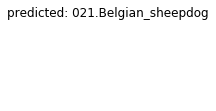

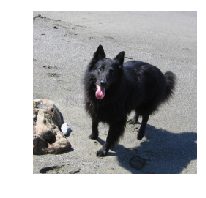

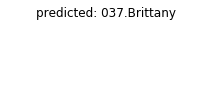

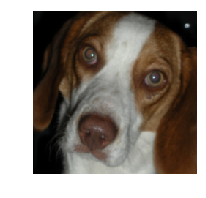

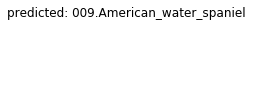

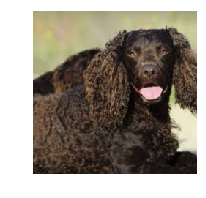

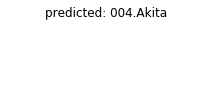

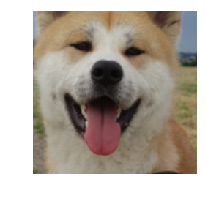

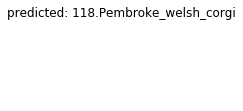

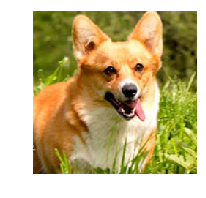

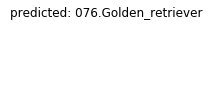

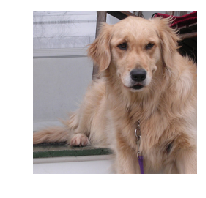

In [239]:
visualize_model(model_ft)

### Test Accuracy

In [245]:
def test_acc(test_set, model):
    '''Calculates accuracy. Takes as input a PyTorch dataloader object containing images and labels.'''
    model.eval()
    test_acc = 0.0
    running_corrects = 0

    # Iterate over data
    for inputs, labels in test_set:
        inputs = inputs.to(device)
        labels = labels.to(device)        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    test_acc = running_corrects.double() / len(test_set.dataset)

    print('Acc: {:.4f}%'.format(test_acc*100))

    return test_acc

In [246]:
test_acc(dataloaders['test'], model_ft)

Acc: 81.5789%


tensor(0.8158, dtype=torch.float64, device='cuda:0')

---
## Inference

In [247]:
# Instantiate model, load weights, and set model to evaluation mode

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, n_classes)

checkpoint = torch.load('saved_models/resnet18_model_15.ckpt')
model_ft.load_state_dict(checkpoint)
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

### Make Predictions

In [248]:
def predict_breed(image_path):
    '''Predicts the top 3 most likely breeds for a given image.'''
    
    image = Image.open(image_path)

    # Define transformations for the image
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor.cuda()

    # Turn the input into a Variable
    input = Variable(image_tensor)

    # Return the top predictions and confidence scores
    output = model(input)
    softmax = nn.Softmax(dim=1)
    preds = softmax(output)
    top_preds = torch.topk(preds, 3)
    pred_breeds = [class_names[i] for i in top_preds[1][0]]
    confidence = top_preds[0][0]
    
    return pred_breeds, confidence

In [250]:
predict_breed('dogImages/test/047.Chesapeake_bay_retriever/Chesapeake_bay_retriever_03361.jpg')

(['047.Chesapeake_bay_retriever',
  '060.Dogue_de_bordeaux',
  '096.Labrador_retriever'],
 tensor([ 0.9812,  0.0073,  0.0052]))

### Display Predictions

In [254]:
# Create list of test image paths

test_img_paths = sorted(glob('dogImages/test/*/*'))

In [255]:
# Shuffle the list and display first few rows

np.random.shuffle(test_img_paths)
test_img_paths[0:5]

['dogImages/test/076.Golden_retriever/Golden_retriever_05248.jpg',
 'dogImages/test/054.Collie/Collie_03790.jpg',
 'dogImages/test/019.Bedlington_terrier/Bedlington_terrier_01363.jpg',
 'dogImages/test/130.Welsh_springer_spaniel/Welsh_springer_spaniel_08237.jpg',
 'dogImages/test/099.Lhasa_apso/Lhasa_apso_06651.jpg']

In [270]:
def make_prediction(img_paths):

    for img_path in img_paths:   
        print("What's up DOG?!")
        
        # display test image
        _, ax = plt.subplots()
        img = mpimg.imread(img_path)
        _ = ax.imshow(img)
        plt.axis('off')
        plt.show()

        # extract breed from image path
        actual_breed = img_path.split('/')[2].split('.')[1]
        print(f"Actual Breed: {actual_breed}\n")
        
        # display breeds and confidence scores
        breeds, confidence = predict_breed(img_path)
        predictions = ""
        for breed, conf in zip(breeds, confidence):
            if conf > 0.005:
                predictions += f"  - {breed.split('.')[1]} ({(conf*100):.0f}%)\n"
        print(f"Predicted Breed (confidence):\n{predictions}")
        
        # display sample of matching breed images
        fig = plt.figure(figsize=(16,4)) 
        for i, breed in enumerate(breeds):
            subdir = '/'.join(['dogImages/val', breed])
            file = random.choice(os.listdir(subdir))
            path = '/'.join([subdir, file])
            img = mpimg.imread(path)
            ax = fig.add_subplot(1,3,i+1)
            ax.imshow(img.squeeze(), cmap="gray", interpolation='nearest')
            plt.title(breed.split('.')[1])
            plt.axis('off')
        plt.show()
        print("\n"*3)  

What's up DOG?!


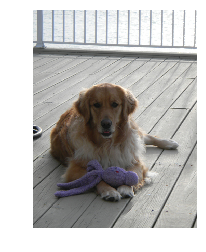

Actual Breed: Golden_retriever

Predicted Breed (confidence):
  - Golden_retriever (97%)
  - Flat-coated_retriever (1%)
  - Labrador_retriever (1%)



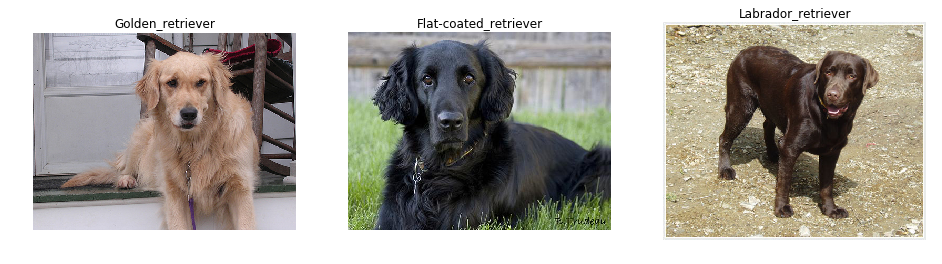





What's up DOG?!


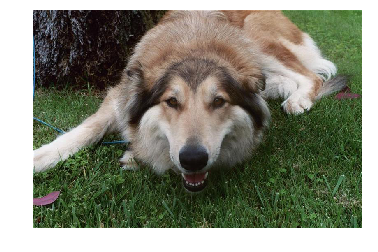

Actual Breed: Collie

Predicted Breed (confidence):
  - Alaskan_malamute (96%)
  - Great_pyrenees (3%)
  - Kuvasz (1%)



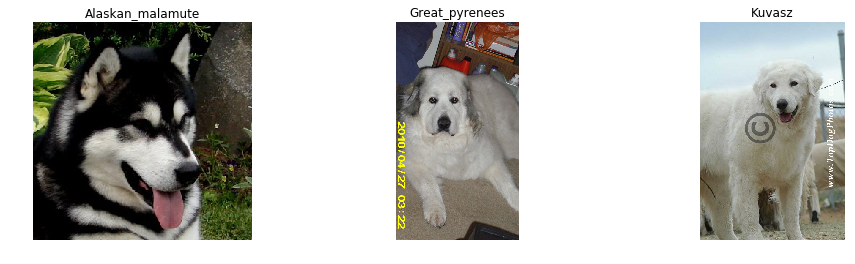





What's up DOG?!


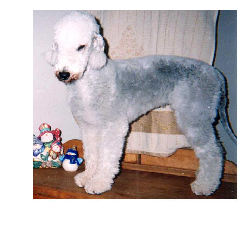

Actual Breed: Bedlington_terrier

Predicted Breed (confidence):
  - Bedlington_terrier (90%)
  - Poodle (7%)
  - Bichon_frise (1%)



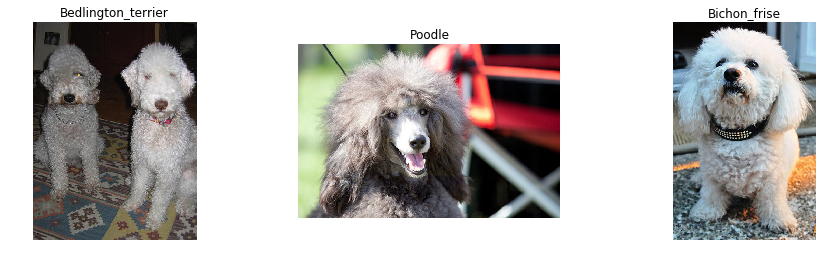





What's up DOG?!


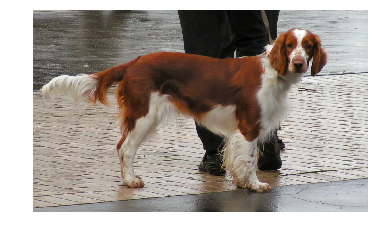

Actual Breed: Welsh_springer_spaniel

Predicted Breed (confidence):
  - Welsh_springer_spaniel (49%)
  - Irish_red_and_white_setter (33%)
  - Brittany (14%)



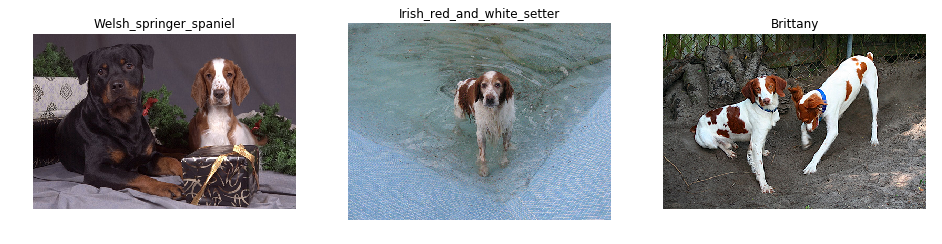





What's up DOG?!


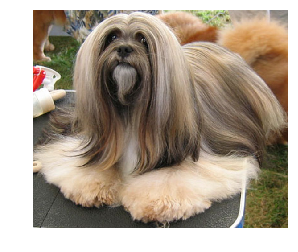

Actual Breed: Lhasa_apso

Predicted Breed (confidence):
  - Lhasa_apso (66%)
  - Maltese (19%)
  - Lowchen (7%)



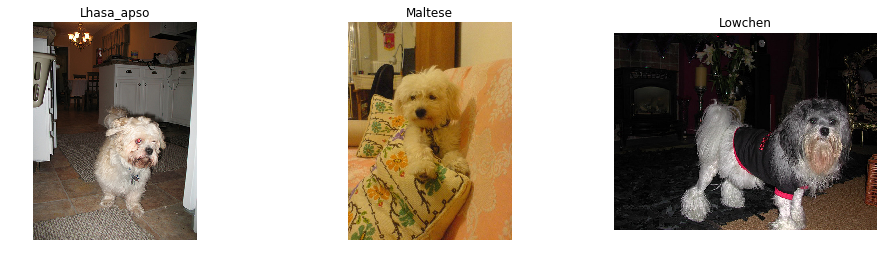

In [271]:
# Test algorithm on images provided in 'test' directory. Make predictions for each image. And show an example 
#  for each prediction.

make_prediction(test_img_paths[0:5])

What's up DOG?!


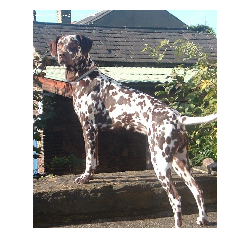

Actual Breed: Dalmatian

Predicted Breed (confidence):
  - German_shorthaired_pointer (50%)
  - Dalmatian (23%)
  - Great_dane (9%)



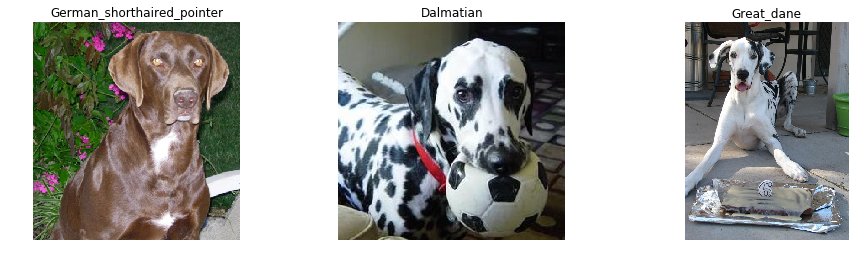





What's up DOG?!


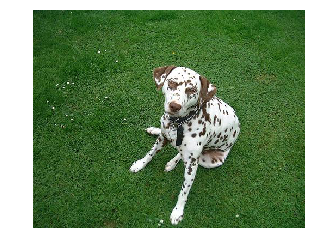

Actual Breed: Dalmatian

Predicted Breed (confidence):
  - Dalmatian (100%)



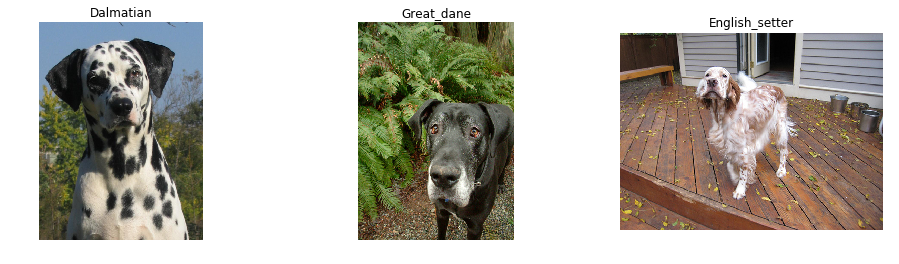





What's up DOG?!


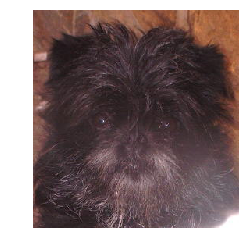

Actual Breed: Affenpinscher

Predicted Breed (confidence):
  - Affenpinscher (70%)
  - Pomeranian (5%)
  - Newfoundland (2%)



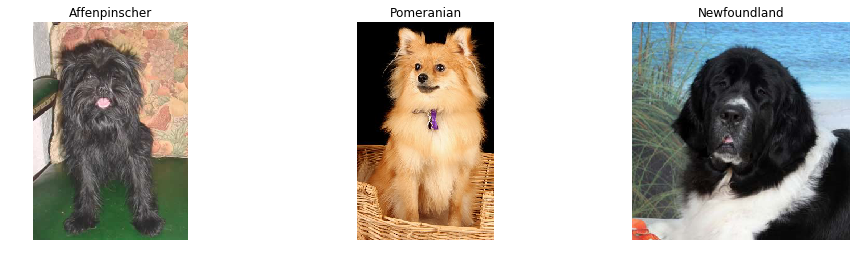





What's up DOG?!


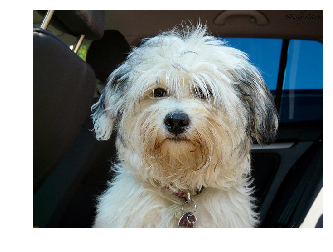

Actual Breed: Havanese

Predicted Breed (confidence):
  - Havanese (84%)
  - Maltese (7%)
  - Lhasa_apso (5%)



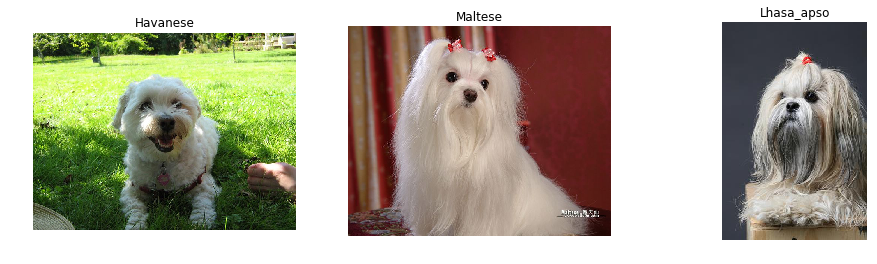





What's up DOG?!


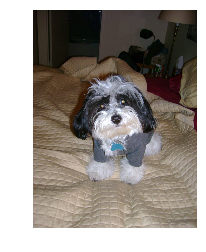

Actual Breed: Havanese

Predicted Breed (confidence):
  - Havanese (67%)
  - Lowchen (19%)
  - Lhasa_apso (12%)



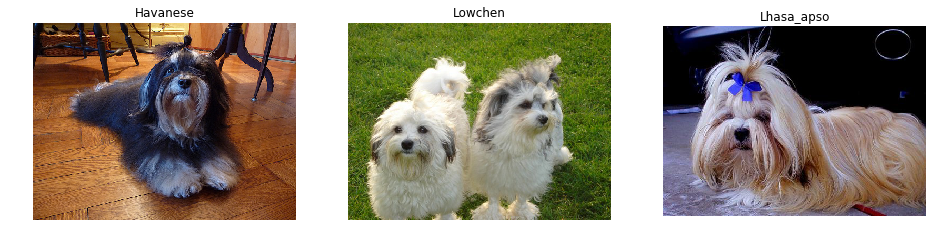

In [272]:
make_prediction(test_img_paths[5:10])

## Notes

1. When you encounter this error, `RuntimeError: cuda runtime error (59) : device-side assert triggered` you may have a mismatch in the expected number of classes (i.e. the number of output nodes in your last fc layer must equal the number of classes in your target data). Once you correct this in the code, you need to restart the kernel and re-run all of the notebook cells. [Here is a link](https://medium.com/@nokkk/notes-for-some-stupid-error-that-i-made-with-pytorch-721ad0397436) describing the issue. 